In [2]:
import tensorflow as tf

IMG_SHAPE = (225 , 225 , 3)
base_model = tf.keras.applications.MobileNetV3Small(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

4334752/4334752 [==============================] - 0s 0us/step


In [3]:
base_model.summary()

Model: "MobilenetV3small"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 225, 225, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 225, 225, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 113, 113, 16  432         ['rescaling[0][0]']              
                                )                                                                 
                                                                                   

In [4]:
## image Augmentation 
from tensorflow.keras.layers.experimental import preprocessing
data_augmentation = tf.keras.Sequential([
  preprocessing.RandomFlip("horizontal_and_vertical"),
  preprocessing.RandomRotation(0.2)
])

In [5]:
base_model.trainable = False

In [6]:
from tensorflow.keras import layers

inputs = layers.Input(shape = (225,225,3),name = "input_layer")
x = data_augmentation(inputs)
# x = inputs
x = base_model(x)
x = layers.GlobalAvgPool2D(name = "pooling_layer")(x)
x = layers.Dense(128,activation = "relu")(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(10)(x)
outputs = layers.Activation("softmax",dtype = tf.float32)(x)
model = tf.keras.Model(inputs,outputs)

In [7]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 225, 225, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 225, 225, 3)       0         
                                                                 
 MobilenetV3small (Functiona  (None, 8, 8, 576)        939120    
 l)                                                              
                                                                 
 pooling_layer (GlobalAverag  (None, 576)              0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 128)               73856     
                                                                 
 dropout (Dropout)           (None, 128)               0     

In [8]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_dir = "/content/drive/MyDrive/1. 텐서플로우 활용 기초 팀플 (3팀)/데이터/피부질환 데이터셋 final/train"
test_dir =  "/content/drive/MyDrive/1. 텐서플로우 활용 기초 팀플 (3팀)/데이터/피부질환 데이터셋 final/test"
val_dir = "/content/drive/MyDrive/1. 텐서플로우 활용 기초 팀플 (3팀)/데이터/피부질환 데이터셋 final/val"

train_data = image_dataset_from_directory(train_dir,label_mode = "categorical",
                                          image_size = (225,225),batch_size = 32,
                                         shuffle = True,seed = 42)
test_data = image_dataset_from_directory(test_dir,label_mode = "categorical",
                                          image_size = (225,225),batch_size = 32,
                                         shuffle = False,seed = 42)
val_data = image_dataset_from_directory(val_dir,label_mode = "categorical",
                                          image_size = (225,225),batch_size = 32,
                                         shuffle = False,seed = 42)

Found 19594 files belonging to 10 classes.
Found 2622 files belonging to 10 classes.
Found 3915 files belonging to 10 classes.


In [9]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import seaborn as sns
import os

early_stop = tf.keras.callbacks.EarlyStopping(monitor = "val_loss",patience = 6,
                                             min_delta = 0.0001)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss",factor = 0.2,
                                                patience = 4,min_lr = 1e-7)

# 체크포인트 폴더 생성 
base = '/content/drive/MyDrive/피부질환 classification/221208 모바일넷 학습 weights'
checkpoint_dir = os.path.join(base,'checkpoint')
if not os.path.isdir(checkpoint_dir):
    os.makedirs(checkpoint_dir)

#성능이 개선될 때마다 모델 저장 
model_path = checkpoint_dir+  '/{epoch:02d}-{val_accuracy:.4f}.hdf5'

from keras.callbacks import ModelCheckpoint

#각 epoch마다 val_acc 값을 모니터링
#save_best_only=True : 이전보다 성능이 개선됐을때만 저장
checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_accuracy', verbose=1, save_best_only=True)
callbacks_list = [early_stop, reduce_lr, checkpoint]

In [10]:
train_data = train_data.prefetch(buffer_size = tf.data.AUTOTUNE)
test_data = test_data.prefetch(buffer_size = tf.data.AUTOTUNE)
val_data = val_data.prefetch(buffer_size = tf.data.AUTOTUNE)

In [11]:
from keras.models import Sequential
from keras.layers import Dense
import keras
import numpy as np

optimizer = keras.optimizers.Adam(lr=0.0001)

model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer = optimizer, metrics = ["accuracy"])

history_1 = model.fit(train_data, epochs = 50, validation_data=val_data, callbacks=callbacks_list)

Epoch 1/50


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


613/613 [==============================] - ETA: 0s - loss: 1.5033 - accuracy: 0.4678 
Epoch 1: val_accuracy improved from -inf to 0.60920, saving model to /content/drive/MyDrive/피부질환 classification/221208 모바일넷 학습 weights/checkpoint/01-0.6092.hdf5
613/613 [==============================] - 4333s 7s/step - loss: 1.5033 - accuracy: 0.4678 - val_loss: 1.0720 - val_accuracy: 0.6092 - lr: 1.0000e-04
Epoch 2/50
612/613 [============================>.] - ETA: 0s - loss: 1.0874 - accuracy: 0.5931
Epoch 2: val_accuracy improved from 0.60920 to 0.65390, saving model to /content/drive/MyDrive/피부질환 classification/221208 모바일넷 학습 weights/checkpoint/02-0.6539.hdf5
613/613 [==============================] - 75s 122ms/step - loss: 1.0872 - accuracy: 0.5932 - val_loss: 0.9244 - val_accuracy: 0.6539 - lr: 1.0000e-04
Epoch 3/50
612/613 [============================>.] - ETA: 0s - loss: 0.9704 - accuracy: 0.6374
Epoch 3: val_accuracy improved from 0.65390 to 0.66845, saving m

In [12]:
history_2 = model.fit(train_data, epochs = 30, validation_data=val_data, callbacks=callbacks_list)

Epoch 1/30
613/613 [==============================] - ETA: 0s - loss: 0.5387 - accuracy: 0.8004
Epoch 1: val_accuracy improved from 0.78238 to 0.78442, saving model to /content/drive/MyDrive/피부질환 classification/221208 모바일넷 학습 weights/checkpoint/01-0.7844.hdf5
613/613 [==============================] - 75s 121ms/step - loss: 0.5387 - accuracy: 0.8004 - val_loss: 0.5720 - val_accuracy: 0.7844 - lr: 2.0000e-05
Epoch 2/30
613/613 [==============================] - ETA: 0s - loss: 0.5393 - accuracy: 0.7995
Epoch 2: val_accuracy did not improve from 0.78442
613/613 [==============================] - 74s 120ms/step - loss: 0.5393 - accuracy: 0.7995 - val_loss: 0.5726 - val_accuracy: 0.7824 - lr: 2.0000e-05
Epoch 3/30
612/613 [============================>.] - ETA: 0s - loss: 0.5391 - accuracy: 0.8002
Epoch 3: val_accuracy did not improve from 0.78442
613/613 [==============================] - 77s 125ms/step - loss: 0.5391 - accuracy: 0.8003 - val_loss: 0.5712 - val_accuracy: 0

In [13]:
print("Validation Accuracy",model.evaluate(val_data))
print("Testing Accuracy",model.evaluate(test_data))

123/123 [==============================] - 11s 88ms/step - loss: 0.5637 - accuracy: 0.7870
Validation Accuracy [0.5636883974075317, 0.7869731783866882]
82/82 [==============================] - 483s 6s/step - loss: 0.5715 - accuracy: 0.7841
Testing Accuracy [0.571501612663269, 0.7841342687606812]


In [14]:
def vis(history,name) :
    plt.title(f"{name.upper()}")
    plt.xlabel('epochs')
    plt.ylabel(f"{name.lower()}")
    value = history.history.get(name)
    val_value = history.history.get(f"val_{name}",None)
    epochs = range(1, len(value)+1)
    plt.plot(epochs, value, 'b-', label=f'training {name}')
    if val_value is not None :
        plt.plot(epochs, val_value, 'r:', label=f'validation {name}')
    plt.legend(loc='upper center', bbox_to_anchor=(0.05, 1.2) , fontsize=10 , ncol=1)
    
def plot_history(history) :
    key_value = list(set([i.split("val_")[-1] for i in list(history.history.keys())]))
    plt.figure(figsize=(12, 4))
    for idx , key in enumerate(key_value) :
        plt.subplot(1, len(key_value), idx+1)
        vis(history, key)
    plt.tight_layout()
    plt.show()

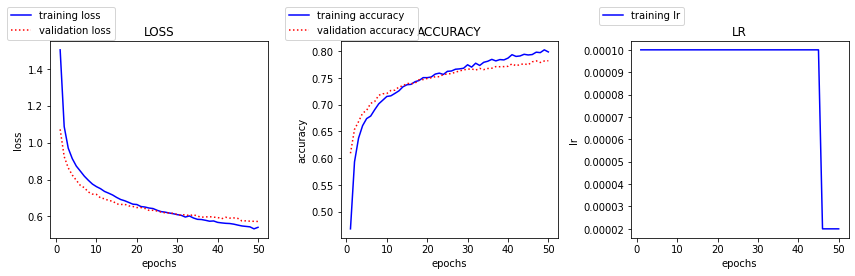

In [15]:
import matplotlib.pyplot as plt

plot_history(history_1)

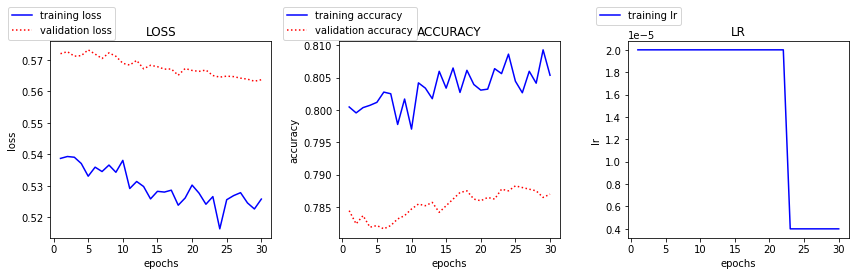

In [16]:
import matplotlib.pyplot as plt

plot_history(history_2)

* Model evaluation

In [17]:
pred_probs = model.predict(test_data)
pred_probs[0]

82/82 [==============================] - 8s 86ms/step


array([1.1647181e-02, 9.3744946e-01, 1.8432687e-06, 3.7470728e-02,
       6.3684536e-07, 4.8899019e-06, 8.7712419e-07, 2.1456084e-09,
       1.1934915e-03, 1.2230949e-02], dtype=float32)

In [19]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
origin_train_data_dir = '/content/drive/MyDrive/1. 텐서플로우 활용 기초 팀플 (3팀)/데이터/피부질환 데이터셋 final/train'
origin_train_data = image_dataset_from_directory(origin_train_data_dir,label_mode = "categorical",
                                          image_size = (224,224),batch_size = 32,
                                         shuffle = True,seed = 42)

class_names = origin_train_data.class_names
print(len(class_names))
print(class_names)

pred_classes = pred_probs.argmax(axis =1)
print(pred_classes[0])
print(class_names[pred_classes[0]])

Found 19594 files belonging to 10 classes.
10
['1. Eczema(습진)', '10. Warts Molluscum(사마귀 및 바이러스 감염)', '2. Melanoma(흑색종)', '3. Atopic Dermatitis(아토피 피부염)', '4. Basal Cell Carcinoma(기저 세포 암)', '5. Melanocytic Nevi (멜라닌 세포 모반)', '6. Benign Keratosis-like Lesions(양성 각화증 유사 병변)', '7. normal(정상)', '8. Seborrheic Keratoses and other Benign Tumors(지루성 각화증 및 기타 양성 종양)', '9. Tinea Ringworm Candidiasis(백선 칸디다증 및 기타 곰팡이 감염)']
1
10. Warts Molluscum(사마귀 및 바이러스 감염)


In [20]:
y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
y_labels[:20]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [21]:
print(len(pred_classes))
print(len(y_labels))

2622
2622


In [22]:
from sklearn.metrics import classification_report
print("Classification report\n",classification_report(y_labels,pred_classes))

Classification report
               precision    recall  f1-score   support

           0       0.57      0.64      0.60       169
           1       0.63      0.58      0.60       211
           2       0.90      0.86      0.88       314
           3       0.61      0.47      0.53       127
           4       0.83      0.87      0.85       335
           5       0.88      0.93      0.90       798
           6       0.72      0.57      0.64       209
           7       1.00      1.00      1.00       103
           8       0.69      0.72      0.71       185
           9       0.58      0.63      0.60       171

    accuracy                           0.78      2622
   macro avg       0.74      0.73      0.73      2622
weighted avg       0.78      0.78      0.78      2622



In [23]:
classification_dict = classification_report(y_labels,pred_classes,output_dict = True)
classification_dict

{'0': {'precision': 0.5714285714285714,
  'recall': 0.6390532544378699,
  'f1-score': 0.6033519553072626,
  'support': 169},
 '1': {'precision': 0.6275510204081632,
  'recall': 0.5829383886255924,
  'f1-score': 0.6044226044226044,
  'support': 211},
 '2': {'precision': 0.8966666666666666,
  'recall': 0.856687898089172,
  'f1-score': 0.8762214983713356,
  'support': 314},
 '3': {'precision': 0.6060606060606061,
  'recall': 0.47244094488188976,
  'f1-score': 0.5309734513274337,
  'support': 127},
 '4': {'precision': 0.8319088319088319,
  'recall': 0.8716417910447761,
  'f1-score': 0.8513119533527697,
  'support': 335},
 '5': {'precision': 0.8820023837902264,
  'recall': 0.9273182957393483,
  'f1-score': 0.9040928527794746,
  'support': 798},
 '6': {'precision': 0.7228915662650602,
  'recall': 0.5741626794258373,
  'f1-score': 0.64,
  'support': 209},
 '7': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 103},
 '8': {'precision': 0.6871794871794872,
  'recall': 0.72432432432

In [24]:
classification_f1_scores = {}
for k,v in classification_dict.items():
    if k == "accuracy":
        break
    else:
        classification_f1_scores[class_names[int(k)]] = v["f1-score"]
classification_f1_scores

{'1. Eczema(습진)': 0.6033519553072626,
 '10. Warts Molluscum(사마귀 및 바이러스 감염)': 0.6044226044226044,
 '2. Melanoma(흑색종)': 0.8762214983713356,
 '3. Atopic Dermatitis(아토피 피부염)': 0.5309734513274337,
 '4. Basal Cell Carcinoma(기저 세포 암)': 0.8513119533527697,
 '5. Melanocytic Nevi (멜라닌 세포 모반)': 0.9040928527794746,
 '6. Benign Keratosis-like Lesions(양성 각화증 유사 병변)': 0.64,
 '7. normal(정상)': 1.0,
 '8. Seborrheic Keratoses and other Benign Tumors(지루성 각화증 및 기타 양성 종양)': 0.7052631578947369,
 '9. Tinea Ringworm Candidiasis(백선 칸디다증 및 기타 곰팡이 감염)': 0.6028169014084507}